# Correlation
* 일자 : 2020-03-19

### 피어슨 상관계수 
* (x와 y가 함께 변하는 정도) / (x와 y가 각각 변하는 정도)

#### [ 사용시 주의점 ]
- 상관관계가 인과관계를 의미하는 것은 아님. 단순히 두 변수의 연관성을 확인하는 것.
- 두 변수가 정규분포일 때 잘 작동한다. 
- 이상치(outlier)에 민감하므로, 이상치는 제거하는 것이 좋음.
- 두 변수가 완전히 동일하면 피어슨 상관계수는 1.0이다. 완전히 반대방향으로 동일하면 -1.0, 전혀 상관 없으면 0이다.

### what I Learned

outlier제거 전과 후 상관계수 차이
> * 99.7percentile 이상값 제거하여 상관관계 다시 살펴봤더니, 상관계수가 outlier제거 전 보다 약간 상승함
    * ss와 aa의 상관계수가 0.17 이었는데 0.39로 증가.
    
스케일링 전 후 상관계수 차이
> * 스케일링 전후로는 상관계수가 차이가 없음.

In [2]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

In [3]:
import chart_studio.plotly as py
# import cufflinks as cf
from plotly.offline import plot
import plotly.express as px

In [4]:
# warning 무시
import warnings
warnings.filterwarnings(action='ignore')

In [6]:
df_notzero=pd.read_excel('./data/yt_data.xlsx')

In [7]:
df_notzero=df_notzero.drop(columns='Unnamed: 0')

In [61]:
# v1 : ad, v2: search, v3: contents
df_notzero.columns=['id','cnt','yt_cnt','yt_prop','aa','ss','cc']

### **원본 데이터로 상관관계 분석**

In [23]:
df_corr=df_notzero[['yt_prop','aa','ss','cc']]
df_corr.head()

,yt_prop,aa,ss,cc
0,0.02,0,2,0
1,0.29,0,0,0
2,0.10,0,0,0
3,0.06,0,0,0
4,0.01,0,0,0


**상관관계 확인**

In [24]:
df_corr.corr()

,yt_prop,aa,ss,cc
yt_prop,1.000000,-0.091848,-0.121276,-0.157065
aa,-0.091848,1.000000,0.168031,0.226419
ss,-0.121276,0.168031,1.000000,0.292377
cc,-0.157065,0.226419,0.292377,1.000000


### **heatmap**
> * aa, ss, cc 모두 yt_prop과의 상관계수가 -0.1~ -0.2 이내이므로 거의 무시될수 있는 선형관계로 봐도 무관.
> * aa와 cc간의 상관계수가 0.2, ss과 cc 간의 상관계수가 0.3으로 약한 양의 상관관계를 띈다.

(4.0, -0.4)

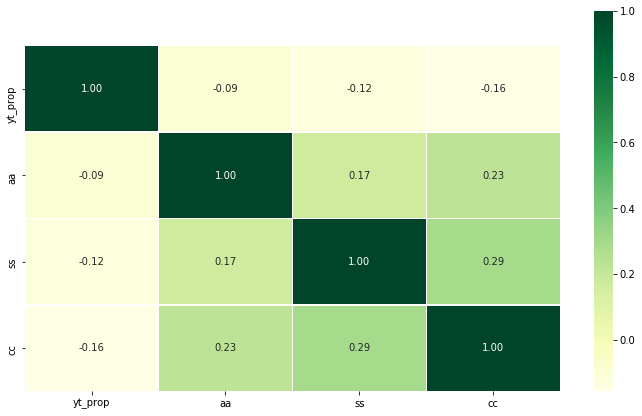

In [25]:
plt.figure(figsize=(12,7))
ax = sns.heatmap(data=df_corr.corr(), annot=True, fmt='.2f', linewidths=.5, cmap="YlGn")
buttom, top= ax.get_ylim()
ax.set_ylim(buttom+0.5, top-0.9)

------------------------------------------
### **outlier제거**
* 제거 기준 : 99.7percentile이상 제거

In [26]:
df_notzero.shape

(515474, 7)

In [27]:
# ad, se, con
P_ss=np.percentile(df_notzero['ss'],[1,99.7])
P_cc=np.percentile(df_notzero['cc'],[1,99.7])
P_aa=np.percentile(df_notzero['aa'],[1,99.7])

In [28]:
print("ss",P_ss[1])
print("cc",P_cc[1])
print("aa",P_aa[1])

ss 146.0
cc 280.0
aa 12.0


In [30]:
df_out_ss=df_notzero[(df_notzero['ss']<P_ss[1])]
df_out_cc=df_notzero[df_notzero['cc']<P_cc[1]]
df_out_aa=df_notzero[df_notzero['aa']<P_aa[1]]
print("ss outlier제거",df_out_ss.shape)
print("cc outlier제거",df_out_cc.shape)
print("aa outlier제거",df_out_aa.shape)

ss outlier제거 (513912, 7)
cc outlier제거 (513907, 7)
aa outlier제거 (513663, 7)


### **outlier제거한 데이터셋**
* outlier제거 전 : 515,474 
* outlier제거 후: 510,822 (99%)

In [33]:
df_out_ss=df_out_ss[['id','ss']].reset_index(drop=True)
df_out_cc=df_out_cc[['id','cc']].reset_index(drop=True)
df_out_aa=df_out_aa[['id','aa']].reset_index(drop=True)
df_yt=df_notzero[['id','yt_prop']].reset_index(drop=True)

In [34]:
df_corr_out=pd.merge(df_yt,
        pd.merge(df_out_ss,
                pd.merge(df_out_cc,df_out_aa,how='left',on='id'),how='left',on='id'),how='left',on='id').dropna(axis=0)
df_corr_out=df_corr_out[['yt_prop','ss','cc','aa']]
df_corr_out.columns=['yt','aa','ss','cc']

In [35]:
df_corr_out.shape

(510822, 4)

In [36]:
df_corr_out.head()

,yt,aa,ss,cc
0,0.02,2.0,0.0,0.0
1,0.29,0.0,0.0,0.0
2,0.10,0.0,0.0,0.0
3,0.06,0.0,0.0,0.0
4,0.01,0.0,0.0,0.0


### **heatmap**
> * aa, ss, cc 모두 yt_prop과의 상관계수는 음의 상관성을 띔.
> * aa와 ss 간의 상관계수가 0.4로 중간정도의 양의상관을 갖고 있다.
> * aa와 cc, ss과 cc 간의 상관계수는 0.22, 0.25로 약한 양의상관성을 갖고 있다.


(4.0, -0.4)

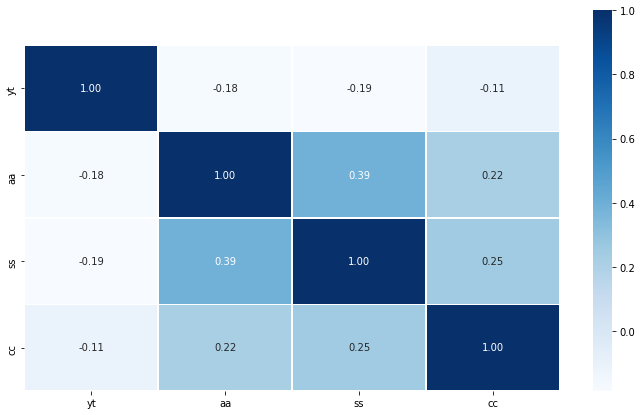

In [37]:
plt.figure(figsize=(12,7))
ax = sns.heatmap(data=df_corr_out.corr(), annot=True, fmt='.2f', linewidths=.5, cmap='Blues')
buttom, top= ax.get_ylim()
ax.set_ylim(buttom+0.5, top-0.9)

### **outlier 제거 and 스케일링**

In [38]:
from sklearn.preprocessing import RobustScaler
robustScaler = RobustScaler()

In [46]:
feature = robustScaler.fit(df_corr_out)
feature = pd.DataFrame(robustScaler.transform(df_corr_out))
feature.head()

,0,1,2,3
0,-0.375,-0.111111,-0.125,0.0
1,3.000,-0.333333,-0.125,0.0
2,0.625,-0.333333,-0.125,0.0
3,0.125,-0.333333,-0.125,0.0
4,-0.500,-0.333333,-0.125,0.0


### **heatmap**

(4.0, -0.4)

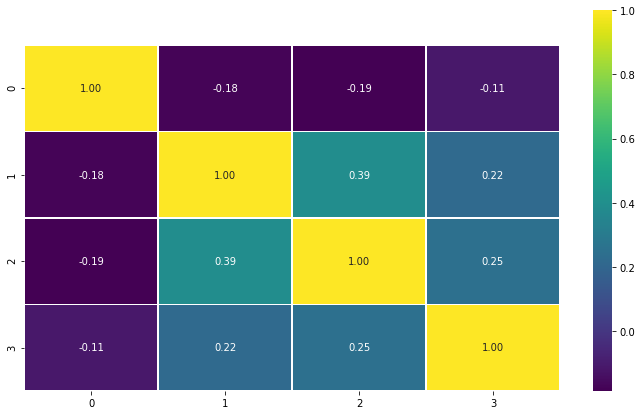

In [60]:
plt.figure(figsize=(12,7))
ax = sns.heatmap(data=feature.corr(), annot=True, fmt='.2f', linewidths=.5, cmap='viridis')
buttom, top= ax.get_ylim()
ax.set_ylim(buttom+0.5, top-0.9)